# Fraud Detection in Python
##### Typical organization loses an estimated 5% of its yearly revenue to fraud. We will apply supervised learning algorithms to detect fraudulent behavior based upon past fraud, and use unsupervised learning methods to discover new types of fraud activities

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

Pandas Configuration Options   

In [4]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

Data File Objects

In [5]:
data = Path.cwd() / 'data' / 'fraud_detection'

ch1 = data / 'chapter_1'
cc1_file = ch1 / 'creditcard_sampledata.csv'
cc3_file = ch1 / 'creditcard_sampledata_3.csv'

ch2 = data / 'chapter_2'
cc2_file = ch2 / 'creditcard_sampledata_2.csv'

ch3 = data / 'chapter_3'
banksim_file = ch3 / 'banksim.csv'
banksim_adj_file = ch3 / 'banksim_adj.csv'
db_full_file = ch3 / 'db_full.pickle'
labels_file = ch3 / 'labels.pickle'
labels_full_file = ch3 / 'labels_full.pickle'
x_scaled_file = ch3 / 'x_scaled.pickle'
x_scaled_full_file = ch3 / 'x_scaled_full.pickle'

ch4 = data / 'chapter_4'
enron_emails_clean_file = ch4 / 'enron_emails_clean.csv'
cleantext_file = ch4 / 'cleantext.pickle'
corpus_file = ch4 / 'corpus.pickle'
dict_file = ch4 / 'dict.pickle'
ldamodel_file = ch4 / 'ldamodel.pickle'

## 1.1 Intro to fraud detection

### 1.1.1 Checking the fraud to non-fraud ratio

In [6]:
df = pd.read_csv(cc3_file)

#### 1.1.1.1 Explore the features available in your dataframe

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [8]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [9]:
# Occurence of fraud to no fraud

fraud = df['Class'].value_counts()

print(fraud)
print("Real fraud percentage in our training data: ", fraud[1]/df.shape[0])
print("Real non-fraud percentage in our training data: ", fraud[0]/df.shape[0])

Class
0    5000
1      50
Name: count, dtype: int64
Real fraud percentage in our training data:  0.009900990099009901
Real non-fraud percentage in our training data:  0.9900990099009901


### 1.1.2 Data Visualization

#### 1.1.2.1 Prep Data

In [10]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    '''
    Convert the DF into 2 variable
    X: data columns (V1-V28)
    y: label
    '''
    X = df.iloc[:,1:30].values
    y = df.Class.values
    return X, y

#### 1.1.2.2 plot_data

In [11]:
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label = "Class 0", alpha = 0.5, linewidth = 0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label = 'Class 1', alpha = 0.5, linewidth = 0.15, c = 'r')
    plt.legend()
    return plt.show()

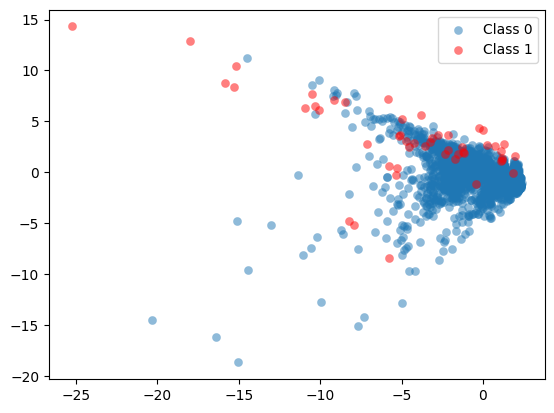

In [12]:
X, y = prep_data(df)
plot_data(X, y)

You can see that the fraud cases are scattered over our data, and how we only have a handful of cases. There is a heavy imbalance in our data.

#### 1.1.2.3 Reproduced using the DataFrame

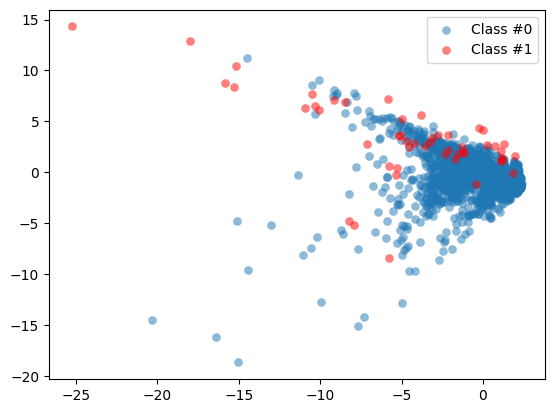

In [13]:
plt.scatter(df.V1[df.Class == 0], df.V2[df.Class == 0], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.V1[df.Class == 1], df.V2[df.Class == 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.legend()
plt.show()


## 1.2 Increase successful detections with data sampling

#### 1.2.0.1 Undersampling

#### 1.2.0.2 Oversampling

#### 1.2.0.3 Random Oversampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

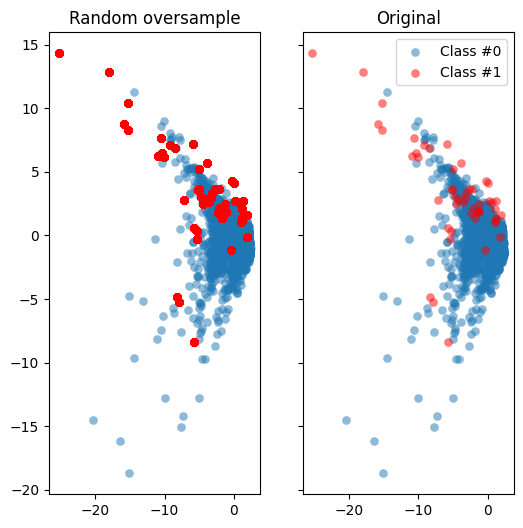

In [15]:
method = RandomOverSampler()
X_resampled, y_resampled = method.fit_resample(X, y)

# compare_plots(X_resampled, y_resampled, X, y)
fig, axs = plt.subplots(1,2, figsize=(6,6), sharey='row')
ax1,ax2 = axs
ax1.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
ax1.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
ax2.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
ax2.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')

ax1.set_title('Random oversample')
ax2.set_title('Original')
plt.legend()
plt.show()

#### 1.2.0.4 SMOTE

In [16]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

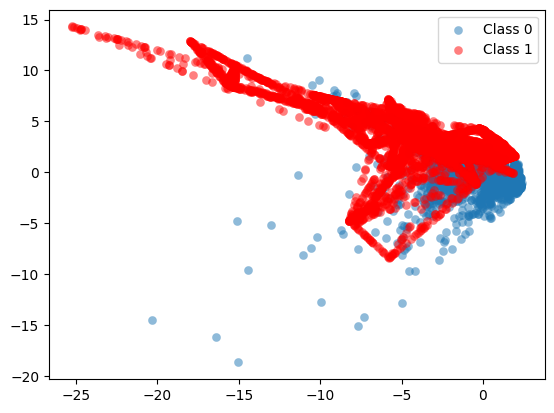

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

plot_data(X_sm, y_sm)

SMOTE is not useful here. In fact, we don't want to oversample frauds in our case since we have way too little fraud compared to non-frauds

#### 1.2.0.5 Undersampling: Tomek Links

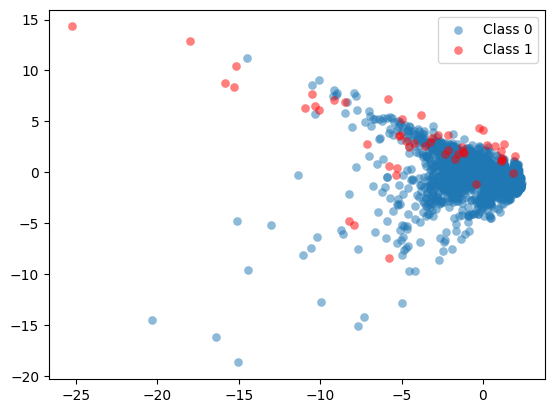

(5048, 29)
(5048,)


In [18]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)

# print('Removed indexes:', id_tl)

plot_data(X_tl, y_tl)
print(X_tl.shape)
print(y_tl.shape)

In [19]:
X_tl.shape
y_tl.shape

(5048,)

### Let's actually use SMOTE to our credit card data, only on train dataset

### 1.3.0 Modeling

#### 1.3.0.1 Linear Regression with original dataset

In [20]:
# Step 1: split the features and labels into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
# Step 2: Define which model to use
model = LinearRegression()

In [22]:
# Step 3: Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [23]:
# Step 4: Obtain model predictions from the test data
y_predicted = model.predict(X_test)

In [24]:
# Step 5: Compare y_test to predictions and obtain performance metrics (r^2 score)
r2_score(y_test, y_predicted)

0.6941036663912437

### 1.3.0.2 Logistic Regression with original data set

In [25]:
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [26]:
y_predicted = model.predict(X_test)

print("Classification report: \n", classification_report(y_test,y_predicted))
conf_matrix = confusion_matrix(y_test, y_predicted)
print("Confusion Matrix: \n", conf_matrix)

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1499
           1       0.92      0.75      0.83        16

    accuracy                           1.00      1515
   macro avg       0.96      0.87      0.91      1515
weighted avg       1.00      1.00      1.00      1515

Confusion Matrix: 
 [[1498    1]
 [   4   12]]


#### 1.3.0.3 Logistic Reg with SMOTE

In [27]:
resampling = BorderlineSMOTE()
model = LogisticRegression(solver = 'liblinear')

In [28]:
pipeline = Pipeline([('Smote', resampling), ('Logistic Regression', model)])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [30]:
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)

In [31]:
print("Classification report: \n", classification_report(y_test,y_predicted))
conf_matrix = confusion_matrix(y_test, y_predicted)
print("Confusion Matrix: \n", conf_matrix)

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1499
           1       0.88      0.88      0.88        16

    accuracy                           1.00      1515
   macro avg       0.94      0.94      0.94      1515
weighted avg       1.00      1.00      1.00      1515

Confusion Matrix: 
 [[1497    2]
 [   2   14]]


In [32]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
pipeline = Pipeline([("Smote", resampling), ('RF Model', model)])
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted)}')
print("Classification report: \n", classification_report(y_test,y_predicted))
conf_matrix = confusion_matrix(y_test, y_predicted)
print("Confusion Matrix: \n", conf_matrix)

Accuracy Score:
0.998019801980198
Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1499
           1       0.88      0.88      0.88        16

    accuracy                           1.00      1515
   macro avg       0.94      0.94      0.94      1515
weighted avg       1.00      1.00      1.00      1515

Confusion Matrix: 
 [[1497    2]
 [   2   14]]


## CC2 dataset

In [33]:
df2 = pd.read_csv(cc2_file)
df2.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,-0.334597,-0.679089,-0.039671,1.372661,-0.732001,-0.344528,1.024751,0.380209,-1.087349,0.364507,0.051924,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,-0.029903,0.279973,0.885685,-0.583912,0.322019,-1.065335,-0.340285,-0.385399,0.216554,0.675646,-0.190851,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,1.465259,-0.188235,-0.976779,0.560550,-0.250847,0.936115,0.136409,-0.078251,0.355086,0.127756,-0.163982,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,-0.165442,0.017562,0.285377,-0.818739,0.637991,-0.370124,-0.605148,0.275686,0.246362,1.331927,0.080978,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,0.484216,-1.967998,-1.818338,-2.036184,0.346962,-1.161316,1.017093,-0.926787,0.183965,-2.102868,-0.354008,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [34]:
X, y = prep_data(df2)
print(X.shape, y.shape)

(7300, 29) (7300,)


In [35]:
# Fraud rate
df2.Class.sum()/df.shape[0]

0.0594059405940594

In [36]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### RandomForestClassifier

In [37]:
# Define the model as the random forest
model = RandomForestClassifier(random_state=5, n_estimators=20)

In [38]:
# Fit the model to our training set
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=5)

In [39]:
# Obtain predictions from the test data 
predicted = model.predict(X_test)

In [40]:
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')
print("Classification report: \n", classification_report(y_test,predicted))
conf_matrix = confusion_matrix(y_test, predicted)
print("Confusion Matrix: \n", conf_matrix)

Accuracy Score:
0.991
Classification report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

Confusion Matrix: 
 [[2097    2]
 [  18   73]]


In [41]:
# import the methods
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)
print( average_precision)
# Obtain precision and recall
precision, recall, _ =precision_recall_curve(y_test, predicted)


0.7890250388880526


In [42]:
# Obtain model probabilities
probs = model.predict_proba(X_test)

# Print ROC_AUC score using probabilities
print(roc_auc_score(y_test, probs[:, 1]))

0.9486882817040034


In [43]:
# Create the parameter grid 
from sklearn.ensemble import RandomForestRegressor


param_grid = {'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300, 1000]}

# Define which model to use
model = RandomForestRegressor()

# Instantiate the grid search model
grid_search_model = GridSearchCV(estimator = model, 
                                 param_grid = param_grid, 
                                 cv = 5,
                                 n_jobs = -1, 
                                 scoring='f1')

In [44]:
# # Fit the grid search to the data
# grid_search_model.fit(X_train, y_train)

# # Get the optimal parameters 
# grid_search_model.best_params_

In [45]:
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [46]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 30)
    max_depth = int(trial.suggest_float("max_depth", 1, 32, log=True))
    max_features =  trial.suggest_categorical("max_features", ["log2", "sqrt"])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,max_features = max_features, criterion = criterion)
    return cross_val_score(
        model, X_train, y_train, n_jobs=-1, cv=3
    ).mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}

[I 2024-02-19 17:13:40,095] A new study created in memory with name: no-name-d43e4ef5-0d79-4175-98c5-801baa4e2439


[I 2024-02-19 17:13:41,707] Trial 0 finished with value: 0.9866933708993701 and parameters: {'n_estimators': 2, 'max_depth': 14.502672766561234, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.9866933708993701.
[I 2024-02-19 17:13:42,792] Trial 1 finished with value: 0.9919772435093369 and parameters: {'n_estimators': 10, 'max_depth': 17.12817133509802, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.9919772435093369.
[I 2024-02-19 17:13:43,756] Trial 2 finished with value: 0.9855193173787948 and parameters: {'n_estimators': 18, 'max_depth': 1.6380270559992913, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.9919772435093369.
[I 2024-02-19 17:13:44,808] Trial 3 finished with value: 0.990802730521578 and parameters: {'n_estimators': 22, 'max_depth': 3.939581685792475, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.9919772435093369.
[I 2024-02-19 17:13:44,979] Trial 4 finished

{'n_estimators': 9,
 'max_depth': 20.241832205808986,
 'max_features': 'sqrt',
 'criterion': 'gini'}

In [47]:
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:20},
                               random_state=5, 
                               n_estimators=27, 
                               max_depth = 32, 
                               max_features = 'sqrt', 
                               criterion = 'entropy',
                               n_jobs= -1,
                               min_samples_leaf=10)

In [48]:
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9704621248213435

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.96      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2096    3]
 [  15   76]]


In [49]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='log2', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9648472061525897

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.96      0.82      0.89        91

    accuracy                           0.99      2190
   macro avg       0.98      0.91      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2096    3]
 [  16   75]]


### Ensemble Method

In [50]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, 
                              criterion='gini', 
                              max_depth=8, 
                              max_features='log2',
                              min_samples_leaf=10, 
                              n_estimators=30, 
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='soft', weights=[1, 4, 1])

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

ROC Score:
0.9706191854834064

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.86      0.90        91

    accuracy                           0.99      2190
   macro avg       0.97      0.93      0.95      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2094    5]
 [  13   78]]


# Unsupervised Model with unlabeled Data

In [51]:
banksim_df = pd.read_csv(banksim_file)
banksim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
banksim_adj_df = pd.read_csv(banksim_adj_file)
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [52]:
banksim_df.shape

(7200, 5)

In [60]:
banksim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       7200 non-null   object 
 1   gender    7200 non-null   object 
 2   category  7200 non-null   object 
 3   amount    7200 non-null   float64
 4   fraud     7200 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 281.4+ KB


In [53]:
banksim_df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [54]:
banksim_adj_df.shape

(7189, 18)

In [55]:
banksim_adj_df.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [65]:
banksim_df.groupby(['category'])[['amount', 'fraud']].mean().sort_values(by = 'fraud', ascending = False)

,amount,fraud
category,,
es_leisure,229.757600,1.000000
es_travel,231.818656,0.944444
es_sportsandtoys,157.251737,0.657895
es_otherservices,149.648960,0.600000
es_hotelservices,172.756245,0.548387
es_health,126.604704,0.242798
es_home,120.688317,0.208333
es_tech,132.852862,0.179487
es_hyper,46.788180,0.125000


In [66]:
banksim_df.fraud.sum()/banksim_df.shape[0]

0.027777777777777776

In [69]:
banksim_df.groupby(['age'])[['amount', 'fraud']].mean()

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


# Fraud Detection using Text